# Simulation Study: MVPC under MAR and MNAR

## Objective

This notebook evaluates the performance of the MVPC algorithm under different missing data mechanisms and sample sizes.

We compare multiple CI test variants in terms of skeleton recovery accuracy.

## Experimental Design

For each sample size n and repetition:

1. Generate a random DAG with 20 variables.
2. Sample data from a linear Gaussian SEM.
3. Inject missingness under:
   - **MAR** (Missing At Random)
   - **MNAR** (Missing Not At Random)
4. Run MVPC using different CI strategies:
   - TD
   - PermC
   - DRW
5. Compare the estimated skeleton to ground truth.

Each configuration is repeated multiple times with new randomly generated DAGs.

## Evaluation Metrics

- **SHD (Structural Hamming Distance)** on the skeleton
- **F1 Score** for edge recovery

Both metrics are computed on the undirected skeleton.

## Study Factors

- Sample sizes: 500, 1000, 2000, 5000, 10000
- Missingness mechanisms: MAR, MNAR
- CI methods: TD, PermC, DRW
- Multiple repetitions per configuration

## Outputs

- Aggregated performance tables
- SHD vs sample size plots
- F1 vs sample size plots
- Grouped bar visualizations

## Purpose

This study analyzes:

- How MVPC scales with increasing sample size
- How missingness mechanisms affect recovery
- Which CI correction performs best under MAR vs MNAR

In [ ]:
import sys
import os


project_root = os.path.abspath("..")

if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added:", project_root)

Project root added: /home/zervaki/Thesis_New


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from data.synthetic_data_generation.synthetic_generator import gen_data

from mvpc.mvpc_pipeline import MVPC
from mvpc.ci_tests.gauss_permc import gauss_ci_td, gauss_ci_permc
from mvpc.ci_tests.gauss_drw import gauss_ci_drw


In [4]:
# SHD helper 
def shd_skeleton(G_est, G_true):
    G_est_sym = ((G_est + G_est.T) > 0).astype(int)
    G_true_sym = ((G_true + G_true.T) > 0).astype(int)
    return np.sum(G_est_sym != G_true_sym)

In [ ]:
def f1_skeleton(G_est, G_true):

    G_est_sym = ((G_est + G_est.T) > 0).astype(int)
    G_true_sym = ((G_true + G_true.T) > 0).astype(int)

    triu_idx = np.triu_indices_from(G_true_sym, k=1)

    est = G_est_sym[triu_idx]
    true = G_true_sym[triu_idx]

    TP = np.sum((est == 1) & (true == 1))
    FP = np.sum((est == 1) & (true == 0))
    FN = np.sum((est == 0) & (true == 1))

    if TP + FP == 0:
        precision = 0.0
    else:
        precision = TP / (TP + FP)

    if TP + FN == 0:
        recall = 0.0
    else:
        recall = TP / (TP + FN)

    if precision + recall == 0:
        return 0.0

    return 2 * precision * recall / (precision + recall)


In [ ]:

sample_sizes = [500, 1000, 2000, 5000, 10000]
n_reps = 15  # number of DAGs / datasets per n

num_var = 20
num_extra_e = 3
num_m = 6

p_missing_h = 0.9
p_missing_l = 0.1

modes = ["mar", "mnar"]  
methods = ["td", "permc", "drw"]


In [7]:
def run_mvpc_all_methods(X_m, adj_true):
    results = {}

    # TD-PC
    mvpc_td = MVPC(indep_test=gauss_ci_td, corr_test=gauss_ci_td, alpha=0.05)
    res_td = mvpc_td.run(X_m)
    G_td = res_td["G_corrected"]
    results["td"] = {
        "shd": shd_skeleton(G_td, adj_true),
        "f1": f1_skeleton(G_td, adj_true),
    }

    # PermC
    mvpc_permc = MVPC(indep_test=gauss_ci_td, corr_test=gauss_ci_permc, alpha=0.05)
    res_permc = mvpc_permc.run(X_m)
    G_permc = res_permc["G_corrected"]
    results["permc"] = {
        "shd": shd_skeleton(G_permc, adj_true),
        "f1": f1_skeleton(G_permc, adj_true),
    }

    # DRW
    mvpc_drw = MVPC(indep_test=gauss_ci_td, corr_test=gauss_ci_drw, alpha=0.05)
    res_drw = mvpc_drw.run(X_m)
    G_drw = res_drw["G_corrected"]
    results["drw"] = {
        "shd": shd_skeleton(G_drw, adj_true),
        "f1": f1_skeleton(G_drw, adj_true),
    }

    return results


In [ ]:
# Main simulation loop /new DAG per repetition

results = []

for n in sample_sizes:
    for rep in range(n_reps):

        base_seed = 1000 * n + rep

        for mode in modes:
            # Generate synthetic data (new DAG each time)
            data_dict = gen_data(
                num_samples=n,
                mode=mode,
                num_var=num_var,
                num_extra_e=num_extra_e,
                num_m=num_m,
                seed=base_seed,
                p_missing_h=p_missing_h,
                p_missing_l=p_missing_l,
            )

            X_m = data_dict["data_m"]
            adj_true = data_dict["ground_truth"]["adj"]

            shd_dict = run_mvpc_all_methods(X_m, adj_true)

            for method, metrics in shd_dict.items():
                results.append({
                    "n": n,
                    "rep": rep,
                    "mode": mode.upper(),
                    "method": method.upper(),
                    "shd": metrics["shd"],
                    "f1": metrics["f1"],
                })


df_results = pd.DataFrame(results)
df_results.head()


In [9]:
df_results.head()

,n,rep,mode,method,shd,f1
0,500,0,MAR,TD,12,0.842105
1,500,0,MAR,PERMC,12,0.842105
2,500,0,MAR,DRW,12,0.842105
3,500,0,MNAR,TD,14,0.820513
4,500,0,MNAR,PERMC,14,0.820513


In [10]:
summary = (
    df_results
    .groupby(["mode", "method", "n"])
    .agg(
        mean_shd=("shd", "mean"),
        std_shd=("shd", "std"),
        n_runs=("shd", "count"),
    )
    .reset_index()
)

summary


,mode,method,n,mean_shd,std_shd,n_runs
0,MAR,DRW,500,16.000000,4.598136,15
1,MAR,DRW,1000,13.866667,4.867775,15
2,MAR,DRW,2000,12.266667,6.540715,15
3,MAR,DRW,5000,10.533333,4.808722,15
4,MAR,DRW,10000,9.600000,6.103863,15
5,MAR,PERMC,500,15.200000,5.171350,15
6,MAR,PERMC,1000,13.600000,4.672106,15
7,MAR,PERMC,2000,11.733333,6.713171,15
8,MAR,PERMC,5000,9.600000,4.732864,15
9,MAR,PERMC,10000,8.266667,5.993647,15


In [11]:
summary_f1 = (
    df_results
    .groupby(["mode", "method", "n"])
    .agg(
        mean_f1=("f1", "mean"),
        std_f1=("f1", "std"),
        n_runs=("f1", "count"),
    )
    .reset_index()
)


In [12]:
summary_f1

,mode,method,n,mean_f1,std_f1,n_runs
0,MAR,DRW,500,0.790771,0.069811,15
1,MAR,DRW,1000,0.815457,0.074113,15
2,MAR,DRW,2000,0.845561,0.094001,15
3,MAR,DRW,5000,0.873726,0.055723,15
4,MAR,DRW,10000,0.877817,0.068807,15
5,MAR,PERMC,500,0.801216,0.075587,15
6,MAR,PERMC,1000,0.818829,0.072153,15
7,MAR,PERMC,2000,0.852501,0.094825,15
8,MAR,PERMC,5000,0.885380,0.055630,15
9,MAR,PERMC,10000,0.893543,0.067006,15


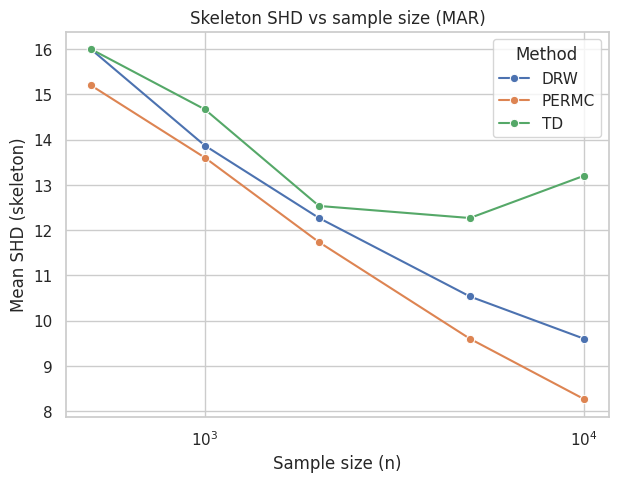

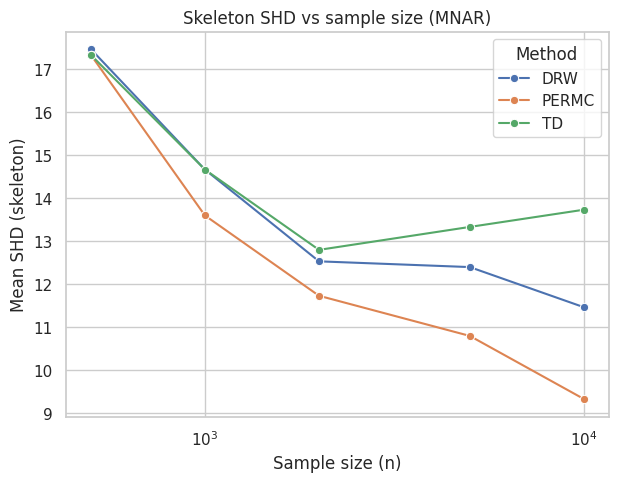

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

for mode in ["MAR", "MNAR"]:
    plt.figure(figsize=(7, 5))
    sub = summary[summary["mode"] == mode]

    sns.lineplot(
        data=sub,
        x="n",
        y="mean_shd",
        hue="method",
        marker="o"
    )

    plt.title(f"Skeleton SHD vs sample size ({mode})")
    plt.xlabel("Sample size (n)")
    plt.ylabel("Mean SHD (skeleton)")
    plt.legend(title="Method")
    plt.xscale("log")  # log-scale on n
    plt.show()


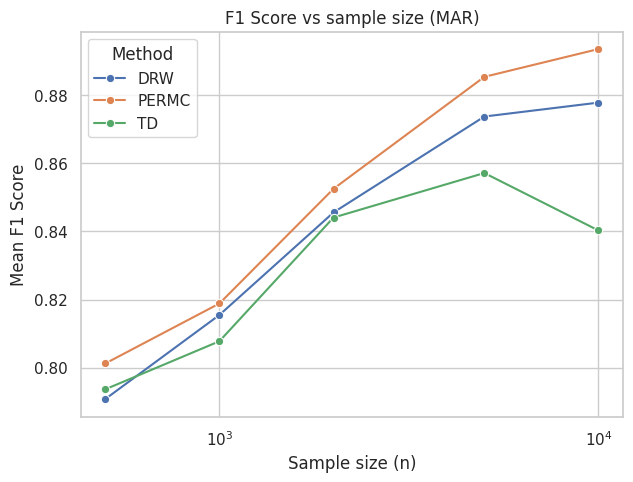

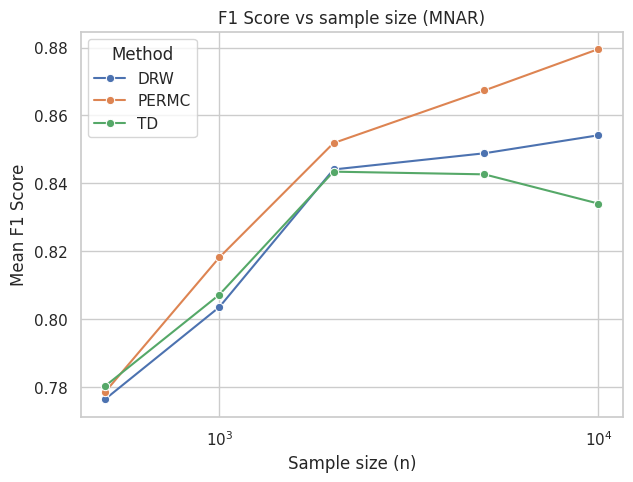

In [ ]:

sns.set(style="whitegrid")

for mode in ["MAR", "MNAR"]:
    plt.figure(figsize=(7, 5))
    sub = summary_f1[summary_f1["mode"] == mode]

    sns.lineplot(
        data=sub,
        x="n",
        y="mean_f1",
        hue="method",
        marker="o"
    )

    plt.title(f"F1 Score vs sample size ({mode})")
    plt.xlabel("Sample size (n)")
    plt.ylabel("Mean F1 Score")
    plt.legend(title="Method")
    plt.xscale("log")   # optional, matches your SHD plot
    plt.show()


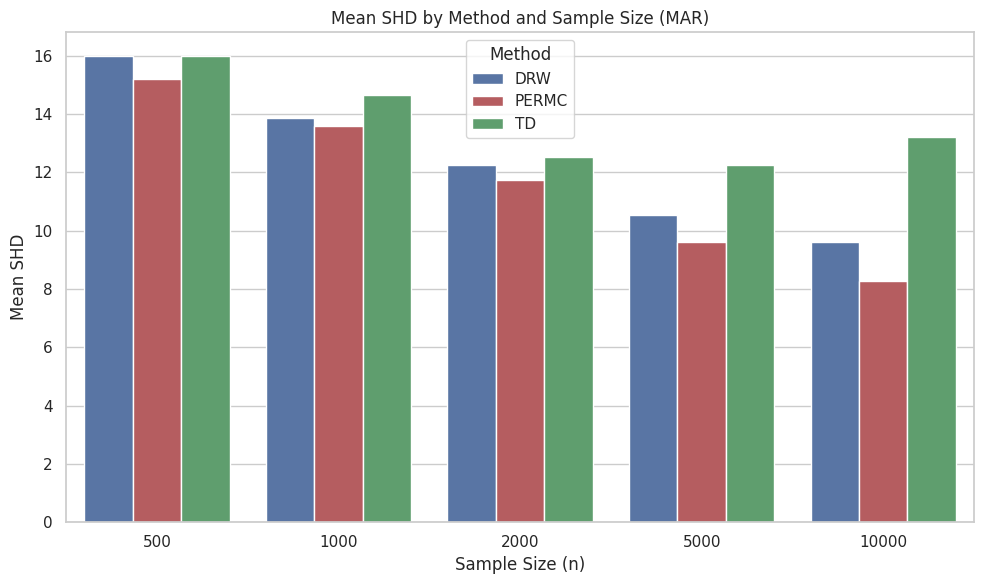

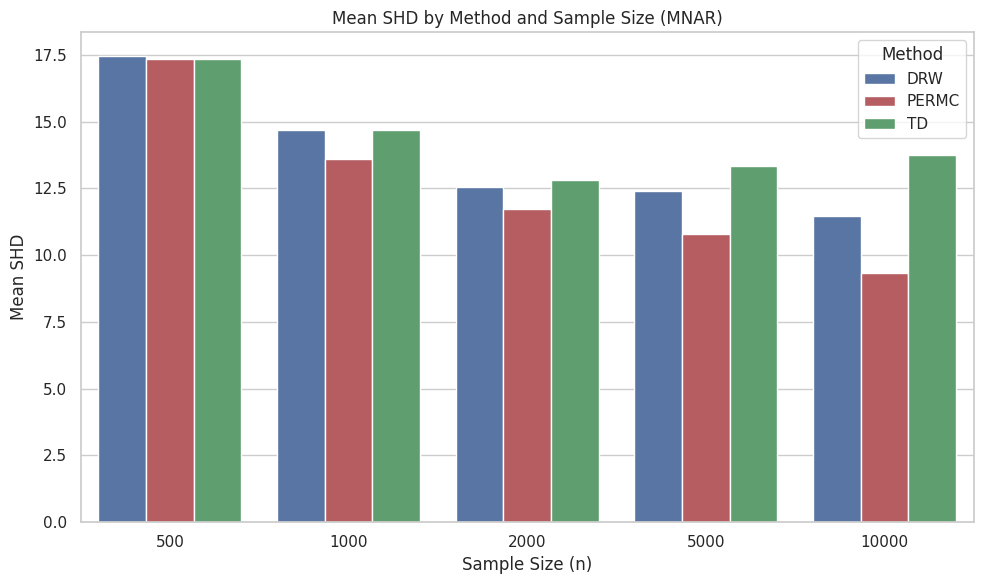

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

def plot_grouped_histogram(df, mode):
    df_mode = df[df["mode"] == mode]

    plt.figure(figsize=(10, 6))

    # Create grouped bar chart
    sns.barplot(
        data=df_mode,
        x="n",
        y="mean_shd",
        hue="method",
        palette=["#4C72B0", "#C44E52", "#55A868"],  # blue, green, red
        errorbar="sd"
    )

    plt.title(f"Mean SHD by Method and Sample Size ({mode})")
    plt.xlabel("Sample Size (n)")
    plt.ylabel("Mean SHD")
    plt.legend(title="Method")
    plt.tight_layout()
    plt.show()

# Plot for MAR
plot_grouped_histogram(summary, "MAR")

# Plot for MNAR
plot_grouped_histogram(summary, "MNAR")


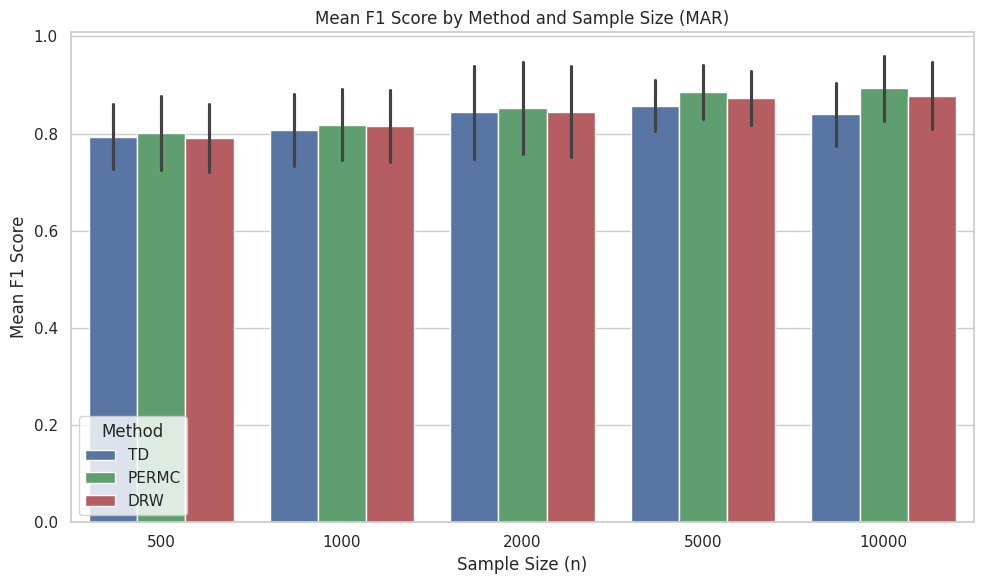

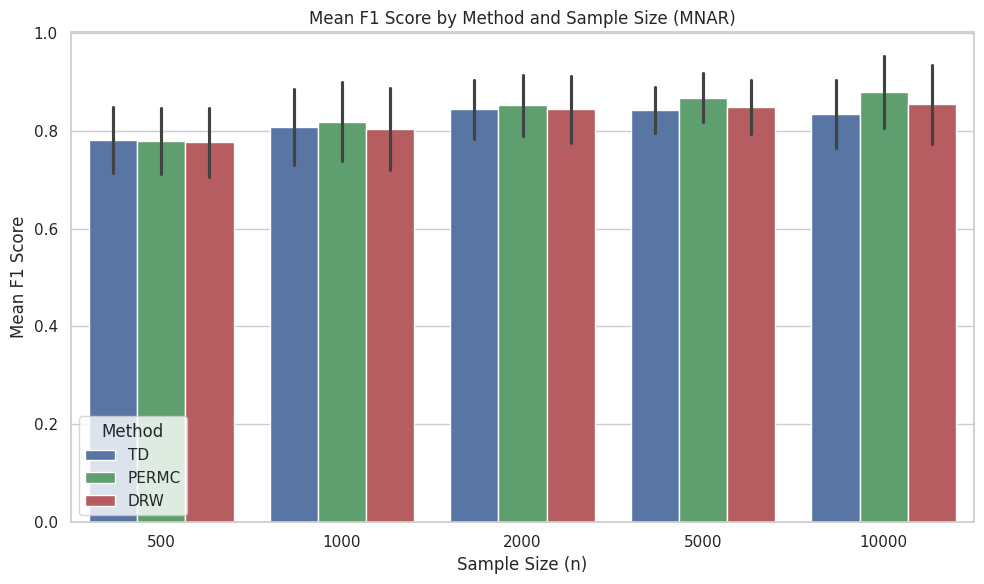

In [17]:
def plot_grouped_histogram_f1(df, mode):
    df_mode = df[df["mode"] == mode]

    plt.figure(figsize=(10, 6))

    sns.barplot(
        data=df_mode,
        x="n",
        y="f1",
        hue="method",
        palette=["#4C72B0", "#55A868", "#C44E52"],
        errorbar="sd"
    )

    plt.title(f"Mean F1 Score by Method and Sample Size ({mode})")
    plt.xlabel("Sample Size (n)")
    plt.ylabel("Mean F1 Score")
    plt.legend(title="Method")
    plt.tight_layout()
    plt.show()

plot_grouped_histogram_f1(df_results, "MAR")
plot_grouped_histogram_f1(df_results, "MNAR")
